In [69]:
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [30]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister,Aer,transpile
from qiskit.circuit import Parameter, ParameterVector
import matplotlib.pyplot as plt

#### Step 1 : We create 20 training data points and 5 testing data points of 2 features from each class.

In [2]:
from qiskit_machine_learning.datasets import ad_hoc_data
#ad_hoc_data randomly generates a toy data that can be fully seperated with ZZFeatureMap

In [3]:
train_data, train_labels, test_data, test_labels = (ad_hoc_data(training_size=20,
                                                                test_size=5,
                                                                n=2,  #number of qubits -can be 2 0r 3
                                                                gap=0.3,
                                                                one_hot=False))

#### Step 2 : Initialize a feature map and PQC

In [5]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

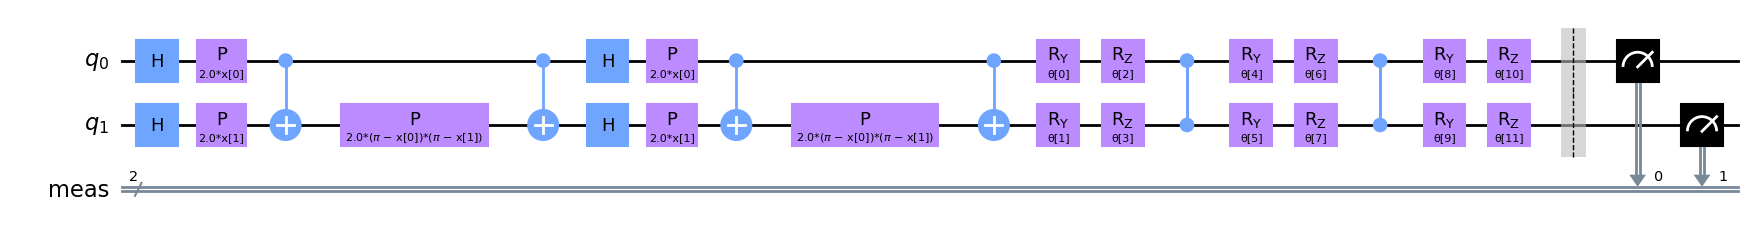

In [8]:
#data encoding using ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=2,reps=2)  #feature_dimension = no of qubits
#variational circuit using TwoLocal circuit
var_form = TwoLocal(2,['ry','rz'],'cz',reps=2)

ad_hoc_circuit = feature_map.compose(var_form)
ad_hoc_circuit.measure_all()
ad_hoc_circuit.decompose().draw('mpl')

#### Step 3 : Associate the data to feature map and variational parameters to variational circuit

In [9]:
def circuit_instance(data, variational):
    parameters = {}
    for i,p in enumerate(feature_map.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return ad_hoc_circuit.assign_parameters(parameters)

In [19]:
#feature_map.ordered_parameters

In [20]:
#var_form.ordered_parameters

#### Step 4 : Class assignment function to calculate the parity of the given bitstring.

In [21]:
#If the parity is even, it returns a 1 label, and if the parity is odd it returns a 0 label.
def parity(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1)%2

#### Step 5 : Function that returns the probability distribution over the label classes.

In [38]:
#Converts a dict of bitstrings and their counts, to parities and their counts
def label_probability(result):
    shots = sum(result.values())
    probabilities = {0:0, 1:0}
    for bitstring, counts in result.items():
        label = parity(bitstring)
        probabilities[label] +=counts/shots
    return probabilities

#### Step 6 : Function that classifies the data

In [23]:
from qiskit import execute

In [32]:
def classification_probability(data, variational):
    circuits = [circuit_instance(d,variational) for d in data]
    result = execute(circuits,Aer.get_backend('qasm_simulator')).result()
    classification = [label_probability(result.get_counts(c)) for c in circuits]
    return classification

#### Step 7: Creating loss and cost functions

In [27]:
def cross_entropy_loss(classification, expected):
    p = classification.get(expected)
    return -np.log(p+1e-10)

def cost_function(data, labels, variational):
    classifications = classification_probability(data,variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification,labels[i])
    cost /= len(data)
    return cost

#### Step 8: Setting up our classical optimizer using SPSA

In [28]:
class OptimizerLog:
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

In [29]:
#Set up optimizer
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=300, callback=log.update)
initial_point = np.random.random(var_form.num_parameters)

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(train_data, train_labels, variational)

/tmp/ipykernel_15039/2433255003.py:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA


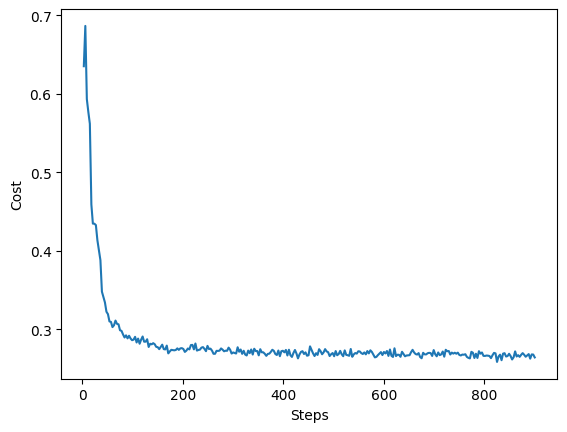

In [39]:
result = optimizer.minimize(fun = objective_function, x0=initial_point)
opt_var = result.x
opt_value = result.fun

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [51]:
np.size(log.evaluations)

300

#### Step 9 : Function to get accuracy of our classifier by running it for test data

In [42]:
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    predictions = [0 if p[0]>=p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy +=1
    accuracy /= len(labels)
    return accuracy, predictions

In [43]:
accuracy, predictions = test_classifier(test_data, test_labels, opt_var)
accuracy

1.0

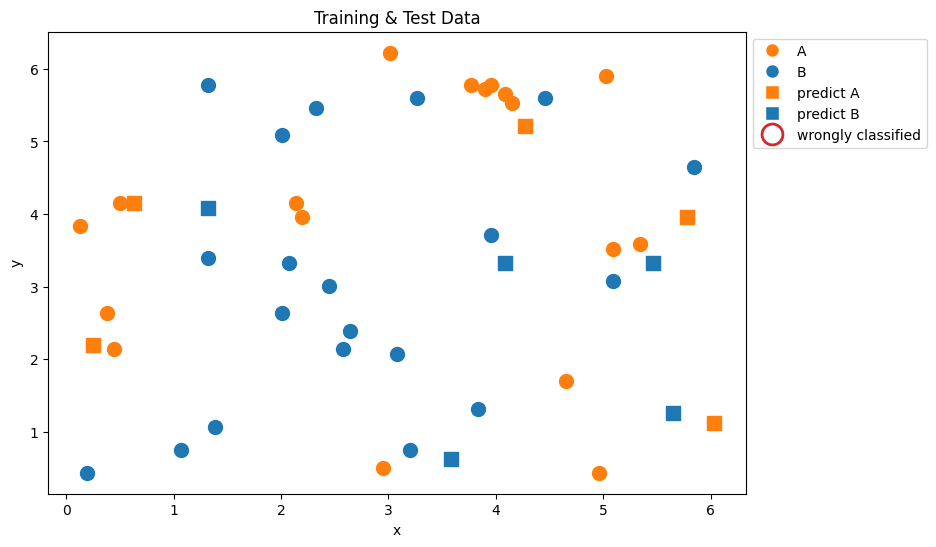

In [45]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(train_data, train_labels):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(test_data, test_labels, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Using Qiskit's built-in VQC class
#### Step 8 and Step 9

In [55]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)
                                      ).toarray()

In [63]:
#Setting up VQC algorithm
from qiskit_machine_learning.algorithms import VQC
log = OptimizerLog()
vqc = VQC(feature_map=feature_map,ansatz=var_form,loss='cross_entropy',
          optimizer=SPSA(callback=log.update),initial_point=initial_point,
          )
vqc.fit(train_data, train_labels_oh)

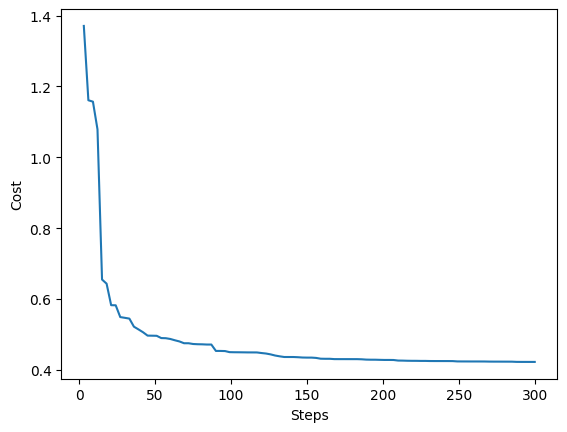

In [64]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [66]:
# score == accuracy
vqc.score(test_data, test_labels_oh)

1.0

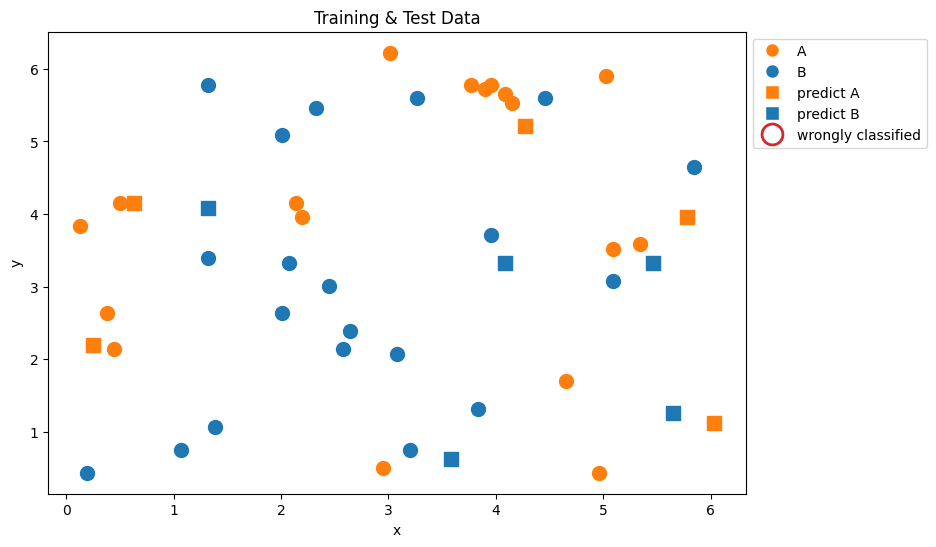

In [68]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(train_data, train_labels_oh):
    COLOR = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=COLOR)

for feature, label, pred in zip(test_data, test_labels_oh,
                                vqc.predict(test_data)):
    COLOR = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=COLOR)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()